In [35]:
from __future__ import division
import numpy as np
import sys

In [36]:
#Universal Constants
c = 3e8
G = 6.67e-11
Msolar = 2e30
AU = 1.49e11 #meters
Kozai = 1 #Turn on/off Kozai osc

In [37]:
def NicePlot():
    
    ax1.set_xlabel('t/T', fontsize = 25)
    ax2.set_xlabel('t/T', fontsize = 25)
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    ax1.tick_params(axis='both', which='major', labelsize=25)


    ax1.set_ylabel('$e$', fontsize = 25)
    ax2.set_ylabel('$a$', fontsize = 25)
    #ax2.set_yscale('log')

    

def sma(M,f):
    #Total mass, orbital frequency
    return (G*M/(2*np.pi*f)**2)**(1/3)

def ang_mom(m1,m2,a):
    M = m1+m2
    return m1*m2 * np.sqrt(G*a/M)

def derivs(y,K,J1,J2,mu,M):
    e = y[0]
    gamma = y[1]
    sma = y[2]
    
    
    de_correction = -304*G**3*mu*M**2/(15*c**5*sma**4) * e*(1-e**2)**(-5/2) * (1 + 121*e**2/304)
    
    de = 5*K*e*(1-e**2)*(1-np.cos(I)**2)*np.sin(2*gamma)/J1 #+de_correction
    #de = de_correction
    
    da = -65*G**3*mu*M**2/(5*c**5*sma**3) *(1-e**2)**(-7/2) * (1 + 73*e**2 / 24 + 37*e**4 / 96)
    da = 0.0
    

    
    dg_part1 = 2*(1-e**2) - 5*(1-e**2 - np.cos(I)**2)*np.sin(gamma)**2
    dg_part2 = (1 - e**2 + 5*e**2 * np.cos(gamma)**2)*np.cos(I)
    dg = 2*K*(dg_part1/J1 + dg_part2/J2)
        

    dg_PN=3/(c**2*sma*(1-e**2)) * (G*M/sma)**(3/2)
    
    dg = dg + dg_PN
        
        
        
    
    if Kozai == 1:
        return np.array((de,dg,da))
    else:
        return np.array((0.0,0.0,0.0)) #turn off derivative changes due to Kozai
    
    
    
def run(m0,m1,f1,e1,beta,m2,e2,I,gamma):
    
    mu1 = (m0*m1)/(m0+m1)
    M = m0+m1
    factor = G*M/c**2
    

    
    
    #Inner Binary calcs
    eps1 = 1-e1**2
    a1 = sma(m0+m1,f1)#semi major axis via K3
    J1 = ang_mom(m0,m1,a1)
    
    
    #Caclualte magntiude of r1
    psi = np.linspace(0,2*np.pi,1000)
    r1 = a1*(1-e1**2) / (1+e1*np.cos(psi))
    BigR1 = np.average(r1)


    #Outer Binary
    eps2 = 1-e2**2
    a2 = beta*a1
    J2 = ang_mom(m0+m1,m2,a2)
    
        
    #Caclualte magntiude of r2
    r2 = a2*(1-e2**2) / (1+e2*np.cos(psi))
    BigR2 = np.average(r2)
            
    
    #Check if we satisfy the weak coupling conditions
    condition1 = m2*(BigR1/BigR2)**3 / M
    condition2 = mu1*(BigR1/BigR2)**2 / M
    print ('Running:',beta, condition1,condition2)
    
    #Other
    K = 3*G*m0*m1*m2*a1**2 / (8*(m0+m1) * a2**3*(1-e2**2)**(3/2))
    

    
    #RK integration
    h = 5000 #Stepsize . seconds
    Tfinal = 5  #years
    Tf = 5*365*24*3600 #seconds
    
    nsteps = int(Tf / h) 
    print ('NS=', nsteps)
    out = np.zeros((nsteps,4)) #t,e,gamma,a
    yn = np.array((e1,gamma,a1))
    
    t = 0
    counter = 0
    while t < Tf:

        k1 = h * derivs(yn,K,J1,J2,mu1,M)
        k2 = h * derivs(yn + k1/2,K,J1,J2,mu1,M)
        k3 = h * derivs(yn + k2/2,K,J1,J2,mu1,M)
        k4 = h * derivs(yn + k3,K,J1,J2,mu1,M)
        ynew = yn + (k1 + 2*k2 + 2*k3 + k4)/6
        yn = ynew
    
        t = t + h
    

        out[counter,0] = t
        out[counter,1] = yn[0]
        out[counter,2] = yn[1] 
        out[counter,3] = yn[2] 
        
        
        counter = counter + 1
        
        
    #Approximate gamma
    yn = out[0,1:4]
    t = out[:,0]
    gdot = derivs(yn,K,J1,J2,mu1,M)[1]
    approx_gamma = t*gdot + gamma
    
    #Approximate e
    CC = np.log(e1) - 0.5*np.log(1-e1**2)
    AA = 5*K*(1-np.cos(I)**2)/J1
    alpha = -AA*np.cos(2*approx_gamma)/(2*gdot) + CC
    
    
    approx_e = np.exp(alpha)/np.sqrt(1+np.exp(2*alpha))
    print (approx_e)
    
  
        
        
        
    return out[:,0]/(60*60*24*365), out[:,1], out[:,2], out[:,3]/factor, approx_gamma, approx_e


    



Parameters relating to the inner binary: $m0, m1,f1,e1$

Parameters relating to the outer binary: $m2,e2,a2,e2$. The semi-major axis is calculated in relation to the SMA of the inner binary e.g. $a_2 = 100 a_1$

Shared parameters included the inclination $I$ which is the inclination of the inner orbit w.r.t the outer orbit and $\gamma$ which specifies the argument of periastron. 

The timescale of KL oscillation is given by

$$t_{\rm KL} = \sqrt{\frac{M a_2^6 \epsilon_1 \epsilon_2^3}{G m_2^2 a_1^3}} \sim \dot{e}^{-1}$$

If we express the $a_2$ in terms of $a_1$ times some scale factor $\beta$ ($a_2 = \beta a_1$) then:

$$t_{\rm KL} = \sqrt{\frac{M  \epsilon_1 \epsilon_2^3}{G m_2^2 } \beta^6 a_1^3} $$


Running: 20 2.6435134331371727e-05 0.0007325352421262655
NS= 31536
[0.50067409 0.50134746 0.50201909 ... 0.50838868 0.50778925 0.50717821]


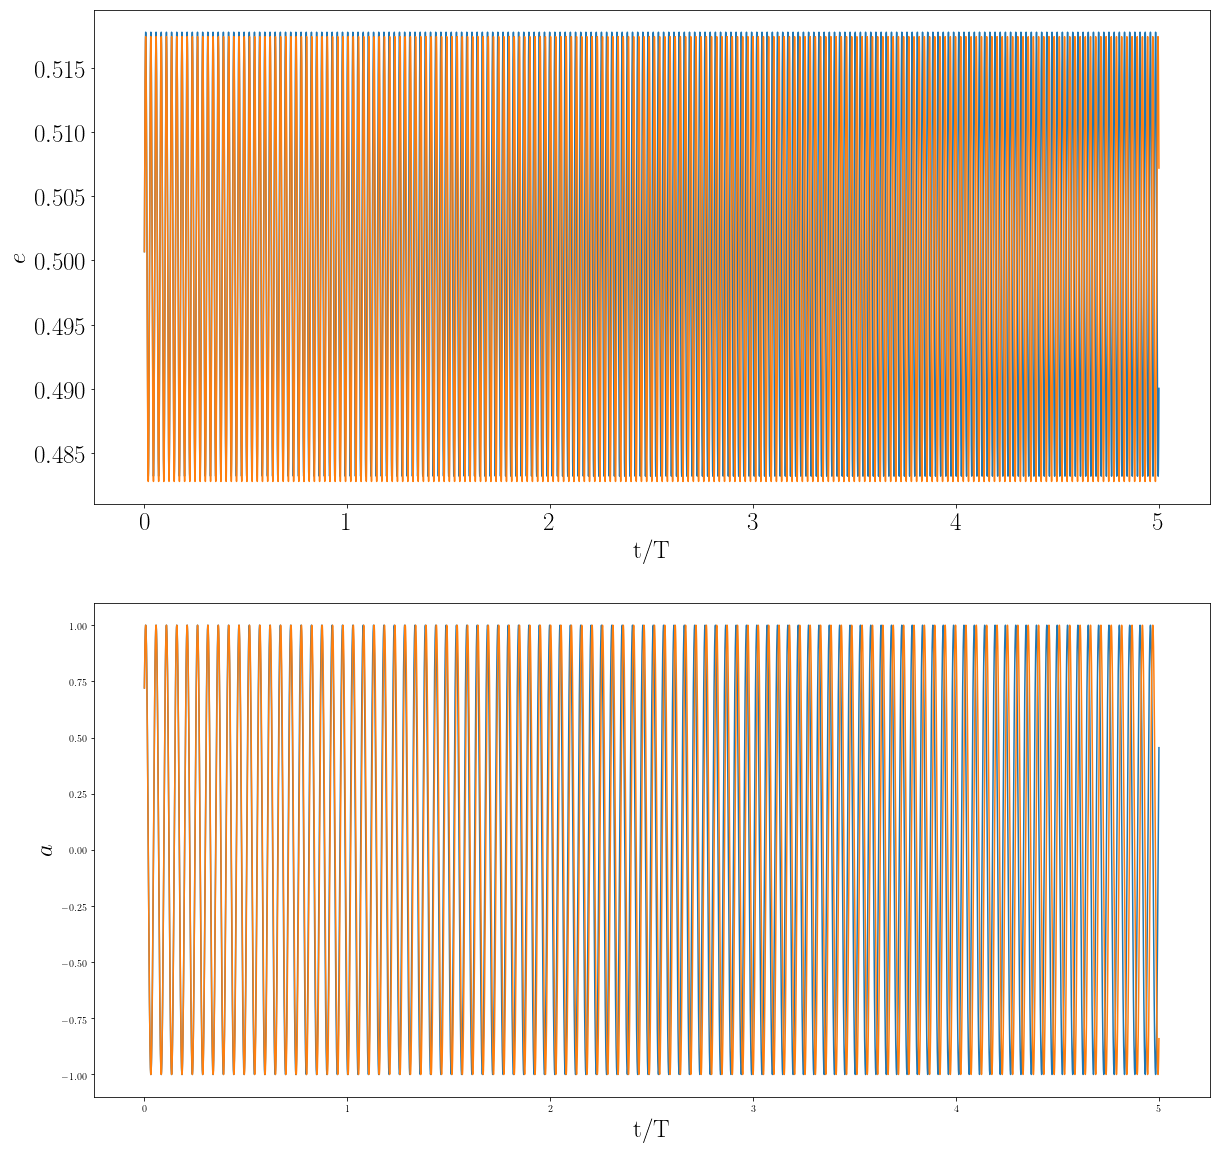

In [38]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((2,1), (0,0)) 
ax2 = plt.subplot2grid((2,1), (1,0)) 


m0 = 30*Msolar
m1 = 30*Msolar
f1 = 1e-3 #orbital frequency
e1 = 0.5 #eccentricity
beta=100
m2 = 10*Msolar
e2 =0.6
I = 60 * np.pi/180.0 #Inclination
gamma = np.pi/4


brange = np.arange(200,300,10)
brange = [20]
for b in brange:
    t,e,g,a,g_approx,e_approx = run(m0,m1,f1,e1,b,m2,e2,I,gamma)
    ax1.plot(t,e)
    ax2.plot(t,np.sin(g))
    ax2.plot(t,np.sin(g_approx))
    ax1.plot(t,e_approx)

#Approximate gamma


#ax2.set_xlim(0,0.1)    
NicePlot()
plt.savefig('Figs/quick2.png', dpi = 300)